In [1]:
import warnings
warnings.simplefilter('ignore')

# Model Training

In this tutorial we are going to train a model from scratch on a molecular dataset from the MD17 collection.
Start by creating a project folder and downloading the dataset.

## Acquiring a dataset

You can obtain the benzene dataset with DFT labels either by running the following command or manually from this [link](http://sgdml.org/?datasetID=benzene2018_dft). Apax uses ASE to read in datasets, so make sure to convert your own data into an ASE readable format (extxyz, traj etc). Be carefull the downloaded dataset has to be modified like in the `apax.untils.dataset.mod_md_datasets` function in order to be readable.

In [2]:
from pathlib import Path
from apax.utils.datasets import download_benzene_DFT, mod_md_datasets, download_md22_benzene_CCSDT

data_path = Path("project")

file_path = download_benzene_DFT(data_path)
file_path = mod_md_datasets(file_path)

## Configuration files

Next, we require a configuration file that specifies the model and training parameters.
In order to get users quickly up and running, our command line interface provides an easy way to generate input templates.
The provided templates come in in two levels of verbosity: minimal and full.
In the following we are going to use a minimal input file. To see a complete list and explanation of all parameters, consult the documentation page LINK.
For more information on the CLI,  simply run `apax -h`.

In [3]:
!apax -h

                                                                                
 Usage: apax [OPTIONS] COMMAND [ARGS]...                                        
                                                                                
╭─ Options ────────────────────────────────────────────────────────────────────╮
│ --version             -V                                                     │
│ --install-completion            Install completion for the current shell.    │
│ --show-completion               Show completion for the current shell, to    │
│                                 copy it or customize the installation.       │
│ --help                -h        Show this message and exit.                  │
╰──────────────────────────────────────────────────────────────────────────────╯
╭─ Commands ───────────────────────────────────────────────────────────────────╮
│ docs       Opens the documentation website in your browser.                  │
│ eval       Starts performi

The following command create a minimal configuration file in the working directory.

In [4]:
!apax template train

Open the resulting `config.yaml` file in an editor of your choice and make sure to fill in the data path field with the name of the data set you just downloaded.
For the purposes of this tutorial we will train on 1000 data points and validate the model on 200 more during the training. Further, the units of the labels have to be specified. Random splitting is done by apax but it is also possible to input a pre-splitted training and validation dataset

The filled in configuration file should look similar to this one.

```yaml
epoch: 1000
data:
    data_path: md17.extexyz
    epochs: 1000
    n_train: 1000
    energy_unit: kcal/mol
    pos_unit: Ang
    ....
```

It also can be modefied with the utils function `mod_config` provided by Apax.


In [5]:
from apax.utils.helpers import mod_config
import yaml


config_path = Path("config.yaml")

config_updates = {
    "n_epochs": 10,
    "data": {
        "experiment": "benzene_dft_cli",
        "directory": "project/models",
        "data_path": str(file_path),
        "energy_unit": "kcal/mol",
        "pos_unit": "Ang",
    }
}
config_dict = mod_config(config_path, config_updates)

with open("config.yaml", "w") as conf:
    yaml.dump(config_dict, conf, default_flow_style=False)


In order to check whether the a configuration file is valid, we provide the `validate` command. This is especially convenient when submitting training runs on a compute cluster.


In [6]:
!apax validate train config.yaml

Success!
config.yaml is a valid training config.


Configuration files are validated using Pydantic and the errors provided by the `validate` command give precise instructions on how to fix the input file.
For example, changing `epochs` to `-1000`, validate will give the following feedback to the user:

In [7]:
config_updates = {
    "n_epochs": -1000,
}
config_dict = mod_config(config_path, config_updates)

with open("error_config.yaml", "w") as conf:
    yaml.dump(config_dict, conf, default_flow_style=False)

In [8]:
!apax validate train error_config.yaml

1 validation error for Config
n_epochs
  Input should be greater than 0 [type=greater_than, input_value=-1000, input_type=int]
    For further information visit https://errors.pydantic.dev/2.6/v/greater_than
Configuration Invalid!


## Training

Model training can be started by running

In [9]:
!apax train config.yaml

INFO | 17:12:25 | Initializing Callbacks
INFO | 17:12:25 | Initializing Loss Function
INFO | 17:12:25 | Initializing Metrics
INFO | 17:12:25 | Running Input Pipeline
INFO | 17:12:25 | Read data file project/benzene_mod.xyz
INFO | 17:12:25 | Loading data from project/benzene_mod.xyz
INFO | 17:12:36 | Precomputing neighborlists
Precomputing NL: 100%|███████████████████████████████████████| 1000/1000 [00:00<00:00, 12876.51it/s]
INFO | 17:12:36 | Computing per element energy regression.
INFO | 17:12:42 | Precomputing neighborlists
Precomputing NL: 100%|█████████████████████████████████████████| 100/100 [00:00<00:00, 12902.77it/s]
INFO | 17:12:43 | Initializing Model
INFO | 17:12:43 | initializing 1 models
INFO | 17:12:49 | Initializing Optimizer
INFO | 17:12:49 | Beginning Training
Epochs: 100%|████████████████████████████████████████| 10/10 [00:27<00:00,  2.77s/it, val_loss=0.63]




During training, apax displays a progress bar to keep track of the validation loss.
This progress bar is optional however and can be turned off in the config. LINK
The default configuration writes training metrics to a CSV file, but TensorBoard is also supported.
One can specify which to use by adding the following section to the input file:

```yaml
callbacks:
    - CSV
```

If training is interrupted for any reason, re-running the above `train` command will resume training from the latest checkpoint.

Furthermore, an Apax trianing can easily be started within a script.

In [10]:
from apax.train.run import run
from apax.utils.helpers import mod_config


config_path = Path("config.yaml")

config_updates = {
    "n_epochs": 100,
    "data": {
        "experiment": "benzene_dft_script",
        "directory": "project/models",
        "data_path": str(file_path),
        "energy_unit": "kcal/mol",
        "pos_unit": "Ang",
    }
}

config_dict = mod_config(config_path, config_updates)

run(config_dict)

Epochs: 100%|██████████████████████████████████████| 100/100 [03:38<00:00,  2.19s/it, val_loss=0.31]


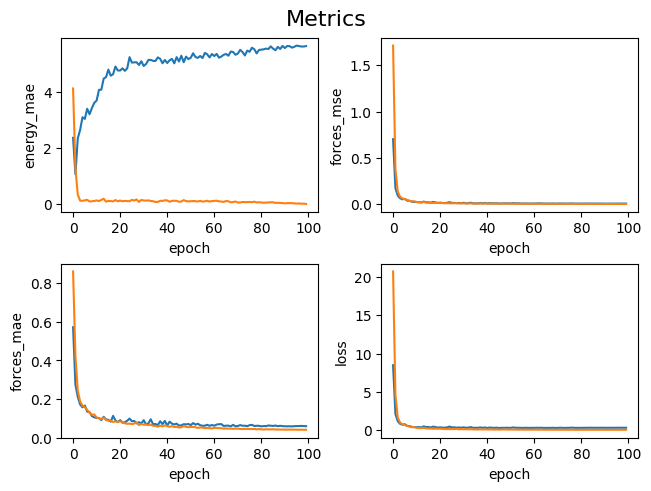

In [11]:
import csv
import matplotlib.pyplot as plt
import numpy as np


path = "project/models/benzene_dft_script/log.csv"

keys = ["energy_mae", "forces_mse", "forces_mae", "loss"]
data_dict = {}

with open(path, 'r') as file:
    reader = csv.reader(file)

    # Extract the headers (keys) from the first row
    headers = next(reader)

    # Initialize empty lists for each key
    for header in headers:
        data_dict[header] = []

    # Read the rest of the rows and append values to the corresponding key
    for row in reader:
        for idx, value in enumerate(row):
            key = headers[idx]
            data_dict[key].append(float(value))

fig, axes = plt.subplots(2, 2, constrained_layout=True)
axes = axes.ravel()
fig.suptitle(f'Metrics', fontsize=16)

for id, key in enumerate(keys):
    val = np.array(data_dict[f"val_{key}"])
    train = np.array(data_dict[f"train_{key}"])
    epoch = np.array(data_dict["epoch"])

    axes[id].plot(epoch, val, label="val data")
    axes[id].plot(epoch, train, label="train data")

    axes[id].set_ylabel(f"{key}")
    axes[id].set_xlabel(r"epoch")

plt.show()

## Evaluation

After the training is completed and we are satisfied with our choice of hyperparameters and vadliation loss, we can evaluate the model on the test set.
We provide a separate command for test set evaluation:


In [20]:
from apax.train.eval import eval_model

eval_model(config_dict, n_test=5000)

Structure: 100%|█████████████████████████████| 5000/5000 [00:21<00:00, 232.32it/s, test_loss=0.0211]


In [16]:
!apax eval config.yaml --n-data 5000

Structure: 100%|██████████████████████████████| 5000/5000 [00:17<00:00, 288.77it/s, test_loss=0.181]


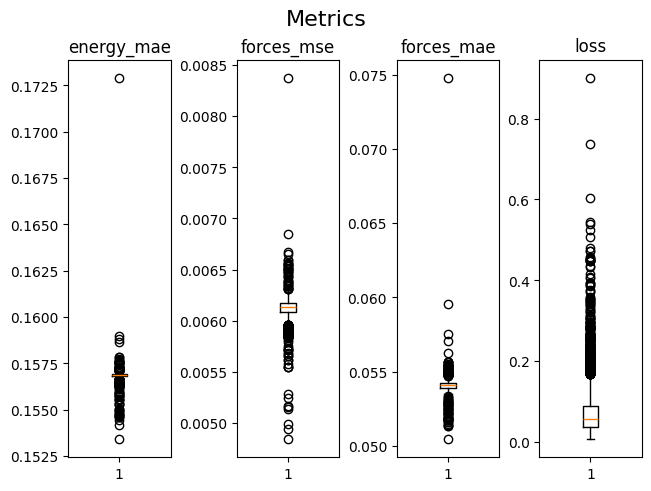

In [24]:
path = "project/models/benzene_dft_script/eval/log.csv"

keys = ["energy_mae", "forces_mse", "forces_mae", "loss"]
data_dict = {}

with open(path, 'r') as file:
    reader = csv.reader(file)

    # Extract the headers (keys) from the first row
    headers = next(reader)

    # Initialize empty lists for each key
    for header in headers:
        data_dict[header] = []

    # Read the rest of the rows and append values to the corresponding key
    for row in reader:
        for idx, value in enumerate(row):
            key = headers[idx]
            data_dict[key].append(float(value))

fig, axes = plt.subplots(1, 4, constrained_layout=True)
axes = axes.ravel()
fig.suptitle(f'Metrics', fontsize=16)

for id, key in enumerate(keys):
    test = np.array(data_dict[f"test_{key}"])

    axes[id].set_title(f'{key}')
    axes[id].boxplot(test)
plt.show()

In [16]:
path = "project/models/benzene_dft_script/eval/log.csv"

keys = ["energy_mae", "forces_mse", "forces_mae", "loss"]
data_dict = {}

with open(path, 'r') as file:
    reader = csv.reader(file)

    # Extract the headers (keys) from the first row
    headers = next(reader)

    # Initialize empty lists for each key
    for header in headers:
        data_dict[header] = []

    # Read the rest of the rows and append values to the corresponding key
    for row in reader:
        for idx, value in enumerate(row):
            key = headers[idx]
            data_dict[key].append(float(value))

fig, axes = plt.subplots(2, 2, constrained_layout=True)
axes = axes.ravel()
fig.suptitle(f'Metrics', fontsize=16)

for id, key in enumerate(keys):
    val = np.array(data_dict[f"val_{key}"])
    train = np.array(data_dict[f"train_{key}"])
    epoch = np.array(data_dict["epoch"])

    axes[id].plot(epoch, val, label="val data")
    axes[id].plot(epoch, train, label="train data")

    axes[id].set_ylabel(f"{key}")
    axes[id].set_xlabel(r"epoch")

plt.show()

ValueError: could not convert string to float: 'NA'


TODO pretty print results to the terminal

Congratulations, you have successfully trained and evaluated your first apax model!

## A Closer Look At Training Parameters

| Parameter                  | Default Value                  | Description                                                                 |
|----------------------------|--------------------------------|-----------------------------------------------------------------------------|
| **n_epochs**               | `<NUMBER OF EPOCHS>`           | Number of training epochs.                                                  |
| **seed**                   | 1                              | Seed for initializing random numbers.                                       |
| **patience**               | None                           | Number of epochs without improvement before training termination.          |
| **n_models**               | 1                              | Number of models trained simultaneously.                                    |
| **n_jitted_steps**         | 1                              | Number of train batches in a compiled loop. Can speed up for small batches. |
| **Data**                   |                                |                                                                             |
| directory                  | models/                        | Path to directory where training results and checkpoints are written.      |
| experiment                 | apax                           | Model name distinguishing from others in directory.                         |
| data_path                  | `<PATH>`                       | Path to single dataset file.                                               |
| train_data_path            | `<PATH>`                       | Path to training dataset.                                                   |
| val_data_path              | `<PATH>`                       | Path to validation dataset.                                                 |
| test_data_path             | `<PATH>`                       | Path to test dataset.                                                       |
| n_train                    | 1000                           | Number of training data points.                                             |
| n_valid                    | 100                            | Number of validation data points.                                           |
| batch_size                 | 32                             | Number of training examples evaluated at once.                             |
| valid_batch_size           | 100                            | Number of validation examples evaluated at once.                           |
| shift_method               | "per_element_regression_shift" | Method for shifting.                                                        |
| shift_options              | energy_regularization: 1.0     | Regularization magnitude for energy regression.                             |
| shuffle_buffer_size        | 1000                           | Size of `tf.data` shuffle buffer.                                           |
| pos_unit                   | Ang                            | Positional unit.                                                            |
| energy_unit                | eV                             | Energy unit.                                                                |
| additional_properties_info |                                | Dictionary of property name, shape pairs.                                   |
| **Model**                  |                                |                                                                             |
| n_basis                    | 7                              | Number of Gaussian basis functions.                                         |
| n_radial                   | 5                              | Number of contracted basis functions.                                      |
| nn                         | [512, 512]                     | Hidden layers and units.                                                    |
| r_max                      | 6.0                            | Maximum position of first basis function's mean.                           |
| r_min                      | 0.5                            | Descriptor cutoff radius.                                                   |
| use_zbl                    | false                          | Use Zero-Body-Loss.                                                         |
| b_init                     | normal                         | Initialization scheme for biases.                                           |
| descriptor_dtype           | fp64                           | Descriptor data type.                                                       |
| readout_dtype              | fp32                           | Readout data type.                                                          |
| scale_shift_dtype          | fp32                           | Scale/Shift data type.                                                      |
| **Loss**                   |                                |                                                                             |
| loss_type                  | structures                     | Weighting scheme for atomic contributions.                                 |
| name                       | energy                         | Quantity keyword.                                                           |
| weight                     | 1.0                            | Weighting factor in loss function.                                          |
| name                       | forces                         | Quantity keyword.                                                           |
| weight                     | 4.0                            | Weighting factor in loss function.                                          |
| **Metrics**                |                                |                                                                             |
| name                       | energy                         | Quantity keyword.                                                           |
| reductions                 |                                | List of reductions on target-prediction differences.                        |
| name                       | forces                         | Quantity keyword.                                                           |
| reductions                 | mae, mse                       | Reductions on target-prediction differences.                               |
| **Optimizer**              |                                |                                                                             |
| opt_name                   | adam                           | Optimizer name.                                                             |
| opt_kwargs                 | {}                             | Optimizer keyword arguments.                                                |
| emb_lr                     | 0.03                           | Learning rate for elemental embedding contraction coefficients.            |
| nn_lr                      | 0.03                           | Learning rate for neural network parameters.                                |
| scale_lr                   | 0.001                          | Learning rate for elemental output scaling factors.                        |
| shift_lr                   | 0.05                           | Learning rate for elemental output shifts.                                  |
| zbl_lr                     | 0.001                          | Learning rate for Zero-Body-Loss.                                           |
| transition_begin           | 0                              | Training steps before linear learning rate schedule.                        |
| **Callbacks**              |                                |                                                                             |
| name                       | csv                            | Callback name.                                                              |
| **Progress Bar**           |                                |                                                                             |
| disable_epoch_pbar         | false                          | Disable epoch progress bar.                                                 |
| disable_nl_pbar            | false                          | Disable NL precomputation progress bar.                                     |
| **Checkpoints**            |                                |                                                                             |
| ckpt_interval              | 1                              | Epochs between checkpoints.                                                 |
| base_model_checkpoint     | null                           | Path to pre-trained model checkpoint.                                       |
| reset_layers               | []                             | List of layers to reinitialize parameters.                                  |


#TODO add all options to description of the parameter example ïsolated_atoms_shift and per_element_regression_shift

- **n_epochs**: `<NUMBER OF EPOCHS>`
  - Number of training epochs.



- **seed**: 1
  - Seed for initializing random numbers.



- **patience**: None
  - Number of epochs without improvement before training termination.



- **n_models**: 1
  - Number of models trained simultaneously.



- **n_jitted_steps**: 1
  - Number of train batches in a compiled loop. Can speed up for small batches.

- **Data**
  - directory: models/
    - Path to directory where training results and checkpoints are written.

  - experiment: apax
    - Model name distinguishing from others in directory.

  - data_path: `<PATH>`
    - Path to single dataset file.

  - train_data_path: `<PATH>`
    - Path to training dataset.

  - val_data_path: `<PATH>`
    - Path to validation dataset.

  - test_data_path: `<PATH>`
    - Path to test dataset.

  - n_train: 1000
    - Number of training data points.
    
  - n_valid: 100
    - Number of validation data points.
    
  - batch_size: 32
    - Number of training examples evaluated at once.
    
  - valid_batch_size: 100
    - Number of validation examples evaluated at once.
    
  - shift_method: "per_element_regression_shift"
    - Method for shifting.
    
  - shift_options: energy_regularization: 1.0
    - Regularization magnitude for energy regression.
    
  - shuffle_buffer_size: 1000
    - Size of `tf.data` shuffle buffer.
    
  - pos_unit: Ang
    - Positional unit.
    
  - energy_unit: eV
    - Energy unit.
    
  - additional_properties_info:
    - Dictionary of property name, shape pairs.
    


- **Model**
  - n_basis: 7
    - Number of Gaussian basis functions.

  - n_radial: 5
    - Number of contracted basis functions.

  - nn: [512, 512]
    - Hidden layers and units.

  - r_max: 6.0
    - Maximum position of first basis function's mean.

  - r_min: 0.5
    - Descriptor cutoff radius.

  - use_zbl: false
    - Use emperical Ziegler-Biersack-Littmark potential.

  - b_init: normal
    - Initialization scheme for biases.

  - descriptor_dtype: fp64
    - Descriptor data type.

  - readout_dtype: fp32
    - Readout data type.

  - scale_shift_dtype: fp32
    - Scale/Shift data type.
    


- **Loss**
  - loss_type: structures
    - Weighting scheme for atomic contributions.

  - name: energy
    - Quantity keyword.

  - weight: 1.0
    - Weighting factor in loss function.

  - name: forces
    - Quantity keyword.

  - weight: 4.0
    - Weighting factor in loss function.


- **Metrics**
  - name: energy
    - Quantity keyword.
    
  - reductions:
    - List of reductions on target-prediction differences.
    
  - name: forces
    - Quantity keyword.
    
  - reductions: mae, mse
    - Reductions on target-prediction differences.



- **Optimizer**
  - opt_name: adam
    - Optimizer name.
    
  - opt_kwargs: {}
    - Optimizer keyword arguments.
    
  - emb_lr: 0.03
    - Learning rate for elemental embedding contraction coefficients.
    
  - nn_lr: 0.03
    - Learning rate for neural network parameters.
    
  - scale_lr: 0.001
    - Learning rate for elemental output scaling factors.
    
  - shift_lr: 0.05
    - Learning rate for elemental output shifts.
    
  - zbl_lr: 0.001
    - Learning rate for Zero-Body-Loss.
    
  - transition_begin: 0
    - Training steps before linear learning rate schedule.



- **Callbacks**
  - name: csv
    - Callback name.



- **Progress Bar**
  - disable_epoch_pbar: false
    - Disable epoch progress bar.

  - disable_nl_pbar: false
    - Disable NL precomputation progress bar.


- **Checkpoints**
  - ckpt_interval: 1
    - Epochs between checkpoints.
    
  - base_model_checkpoint: null
    - Path to pre-trained model checkpoint.
    
  - reset_layers: []
    - List of layers to reinitialize parameters.

To remove all the created files and clean up yor working directory run

In [15]:
# !rm -r project config.yaml error_config.yaml eval.log